In [2]:
from tensorflow.keras.datasets import cifar10
import numpy as np


(x_train, _), (x_test, _)=cifar10.load_data()

x_train=x_train/255.0
x_test=x_test/255.0

random_indices=np.random.choice(x_train.shape[0], size=5000, replace=False)
random_images=x_train[random_indices]
np.random.shuffle(random_images)

train_size=int(0.8*random_images.shape[0])

val_size, test_size=int(0.1*random_images.shape[0]), int(0.1*random_images.shape[0])


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
train_images=random_images[:train_size]
val_images=random_images[train_size:train_size+val_size]
test_images=random_images[train_size+val_size:]

In [4]:
train_noisy=train_images + np.random.normal(0, 0.1,train_images.shape)
val_noisy=val_images + np.random.normal(0, 0.1,val_images.shape)
test_noisy=test_images + np.random.normal(0, 0.1,test_images.shape)

In [5]:
print(f"Train set: {train_images.shape}, Noisy: {train_noisy.shape}")
print(f"Validation set: {val_images.shape}, Noisy: {val_noisy.shape}")
print(f"Test set: {test_images.shape}, Noisy: {test_noisy.shape}")


Train set: (4000, 32, 32, 3), Noisy: (4000, 32, 32, 3)
Validation set: (500, 32, 32, 3), Noisy: (500, 32, 32, 3)
Test set: (500, 32, 32, 3), Noisy: (500, 32, 32, 3)


In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import UpSampling2D, Add, Input, Conv2D, MaxPooling2D, Flatten, Dense, Conv2DTranspose, Reshape, BatchNormalization, Activation
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.backend import mean
from tensorflow.image import ssim



from tensorflow.keras.layers import Add

# Input Layer
input_layer = Input(shape=(32, 32, 3))

# Conv Block 1 (Encoder)
x = Conv2D(32, (3, 3), padding="same")(input_layer)
x = BatchNormalization()(x)
x = Activation("relu")(x)
skip1 = x  # Save for residual connection
x = MaxPooling2D((2, 2), padding="same")(x)  # Downsample: 32x32 -> 16x16

# Conv Block 2 (Encoder)
x = Conv2D(64, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
skip2 = x  # Save for residual connection
x = MaxPooling2D((2, 2), padding="same")(x)  # Downsample: 16x16 -> 8x8

# Bottleneck
x = Flatten()(x)
bottleneck = Dense(128, activation="relu")(x)  # Increased bottleneck size for better capacity

# Expand from bottleneck (Decoder)
x = Dense(8 * 8 * 64, activation="relu")(bottleneck)
x = Reshape((8, 8, 64))(x)

# ConvTranspose Block 1 (Decoder)
x = Conv2DTranspose(64, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = UpSampling2D((2, 2))(x)  # Upsample: 8x8 -> 16x16
x = Add()([x, skip2])  # Add residual connection from Conv Block 2

# ConvTranspose Block 2 (Decoder)
x = Conv2DTranspose(32, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = UpSampling2D((2, 2))(x)  # Upsample: 16x16 -> 32x32
x = Add()([x, skip1])  # Add residual connection from Conv Block 1

# Output Layer
output_layer = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)
 # Sigmoid for normalized pixel values

autoencoder=Model(inputs=input_layer, outputs=output_layer)



def perceptual_loss(y_true, y_pred):
    mse_loss = MeanSquaredError()(y_true, y_pred)
    ssim_loss = 1 - mean(ssim(y_true, y_pred, max_val=1.0))  # SSIM is a similarity score
    return mse_loss + ssim_loss


autoencoder.compile(optimizer="adam", loss=perceptual_loss)

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 32)     │            896 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 32, 32, 32)     │            128 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_6 (Activation) │ (None, 32, 32, 32)     │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 16, 16, 32)     │              0 │ activation_6[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 16, 16, 64)     │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 16, 16, 64)     │            256 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_7 (Activation) │ (None, 16, 16, 64)     │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 8, 8, 64)       │              0 │ activation_7[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 4096)           │              0 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │        524,416 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 4096)           │        528,384 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 8, 8, 64)       │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 8, 8, 64)       │         36,928 │ reshape_2[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 8, 8, 64)       │            256 │ conv2d_transpose_2[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_8 (Activation) │ (None, 8, 8, 64)       │              0 │ batch_normalization_8… │
├──────────────────────

 Total params: 1,129,219 (4.31 MB)

 Trainable params: 1,128,835 (4.31 MB)

 Non-trainable params: 384 (1.50 KB)

In [8]:
autoencoder.fit(
    train_noisy, train_images,
    epochs=50,
    batch_size=64,
    validation_data=(val_noisy, val_images)
)


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 764ms/step - loss: 0.4425 - val_loss: 0.5270
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 746ms/step - loss: 0.1723 - val_loss: 0.4072
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 84s 775ms/step - loss: 0.1432 - val_loss: 0.3139
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 766ms/step - loss: 0.1333 - val_loss: 0.2278
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 747ms/step - loss: 0.1277 - val_loss: 0.1712
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 750ms/step - loss: 0.1267 - val_loss: 0.1431
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 773ms/step - loss: 0.1226 - val_loss: 0.1359
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 745ms/step - loss: 0.1216 - val_loss: 0.1308
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 744ms/step - loss: 0.1198 - val_loss: 0.1246
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 84s 772ms/step - loss: 0.1178 - val_loss: 0.1232
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 772ms/step - loss: 0.1185 - val_loss: 0.1207
Epoch 12/50
 3/63 ━━━━━━━━━━━━━━━━━━━━ 38

KeyboardInterrupt: 

In [9]:
denoised_images = autoencoder.predict(test_noisy)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


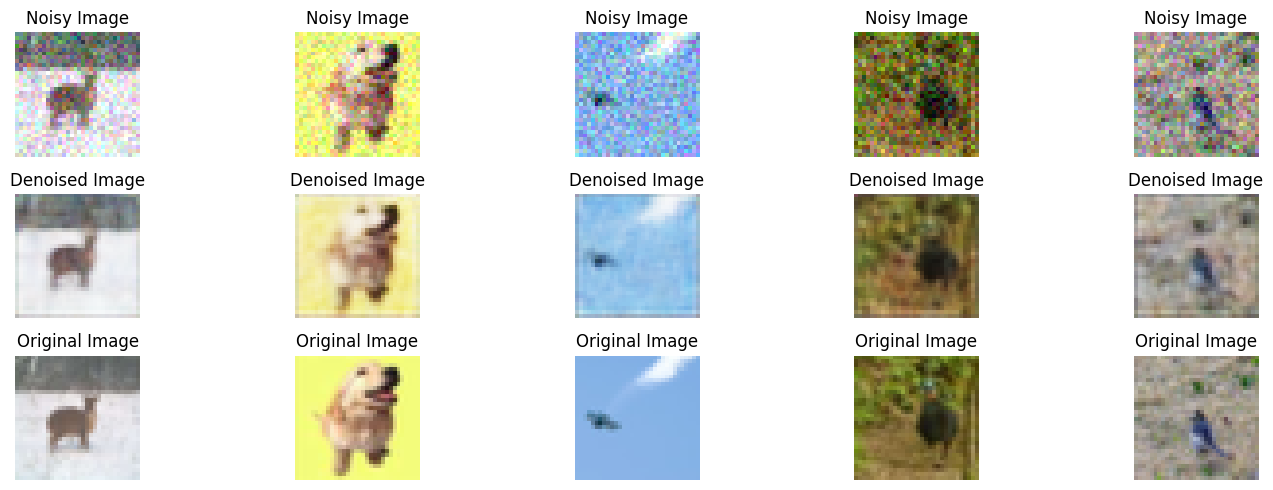

In [10]:
import matplotlib.pyplot as plt

# Pick a few random indices to visualize
num_images = 5  # Number of images to display
random_indices = np.random.choice(test_noisy.shape[0], size=num_images, replace=False)

# Plot noisy, denoised, and original images
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    # Noisy Image
    plt.subplot(3, num_images, i + 1)
    plt.imshow(test_noisy[idx])
    plt.title("Noisy Image")
    plt.axis("off")

    # Denoised Image
    plt.subplot(3, num_images, i + num_images + 1)
    plt.imshow(denoised_images[idx])
    plt.title("Denoised Image")
    plt.axis("off")

    # Original Image
    plt.subplot(3, num_images, i + 2 * num_images + 1)
    plt.imshow(test_images[idx])
    plt.title("Original Image")
    plt.axis("off")

plt.tight_layout()
plt.show()
